# STOCK RANKING

# PART I: FIRST QUANTILE

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format


def get_symbols(df):
    return df['Symbol'].str.replace('.', '-').tolist()


def get_close(df, days):
    return df['Adj Close'].fillna(method='ffill').tail(days).dropna(axis=1, how='any')


def get_annual_return(df):
    return (df/df.shift(252) - 1).dropna(axis=0, how='all')*100


def rank_by_first_quantile(df):
    return df.quantile(0.25).sort_values(ascending=False).index.tolist()


def melt25(df, rank):
    rank = rank[:25]
    df = df[rank].melt(ignore_index=False, var_name='symbol').reset_index()
    df['symbol'] = df['symbol'].astype('category')
    df['symbol'] = df['symbol'].cat.reorder_categories(rank)
    return df


def plot25_close(df, rank, title):
    p = p9.ggplot(data=melt25(df, rank))
    p += p9.theme(figure_size=(10, 9))
    p += p9.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%y'))
    p += p9.scale_y_log10()
    p += p9.geom_line(mapping=p9.aes(x='Date', y='value'))
    p += p9.ggtitle(title)
    p += p9.labs(x='Year', y='Adjusted Close')
    p += p9.facet_wrap('symbol', ncol=5, scales = 'free')
    p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})
    return p


def plot25_annual(df, rank, title):
    p = p9.ggplot(data=melt25(df, rank))
    p += p9.theme(figure_size=(10, 7))
    p += p9.geom_boxplot(mapping=p9.aes(x='symbol', y='value'))
    p += p9.coord_flip()
    p += p9.scale_x_discrete(limits=rank[24::-1])
    p += p9.ggtitle(title)
    p += p9.labs(x='Symbol', y='Annual Return')
    return p

In [2]:
dow_url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
sp5_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

dow_components = pd.read_html(dow_url)[1]
sp5_components = pd.read_html(sp5_url)[0]

dow_symbols = get_symbols(dow_components)
sp5_symbols = get_symbols(sp5_components)

dow_dailey_data = yf.download(dow_symbols)
sp5_dailey_data = yf.download(sp5_symbols)

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  505 of 505 completed


In [3]:
days = 3*252

dow_close = get_close(dow_dailey_data, days)
sp5_close = get_close(sp5_dailey_data, days)

dow_annual = get_annual_return(dow_close)
sp5_annual = get_annual_return(sp5_close)

dow_rank_quantile = rank_by_first_quantile(dow_annual)
sp5_rank_quantile = rank_by_first_quantile(sp5_annual)

dow_title = 'Dow Jones Industrial Average'
sp5_title = 'S&P 500'

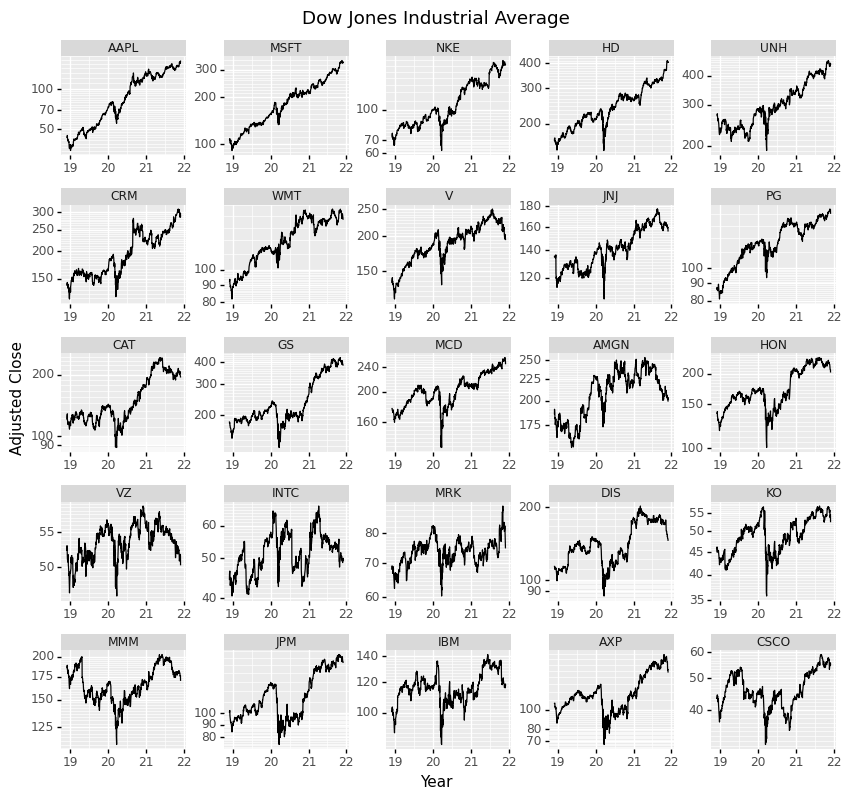

<ggplot: (8778364237695)>

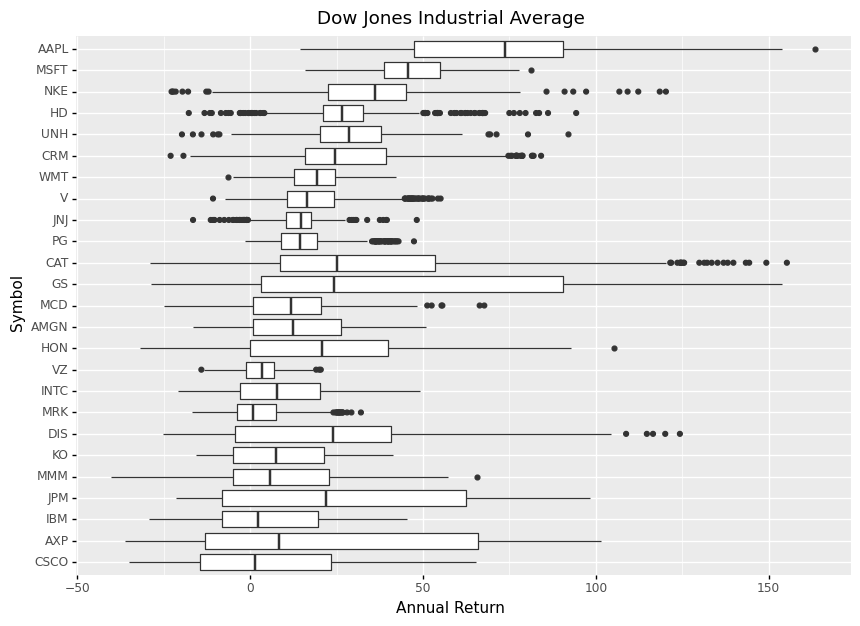

<ggplot: (8778364370445)>

In [4]:
p = plot25_close(dow_close, dow_rank_quantile, dow_title)
display(p)

p = plot25_annual(dow_annual, dow_rank_quantile, dow_title)
display(p)

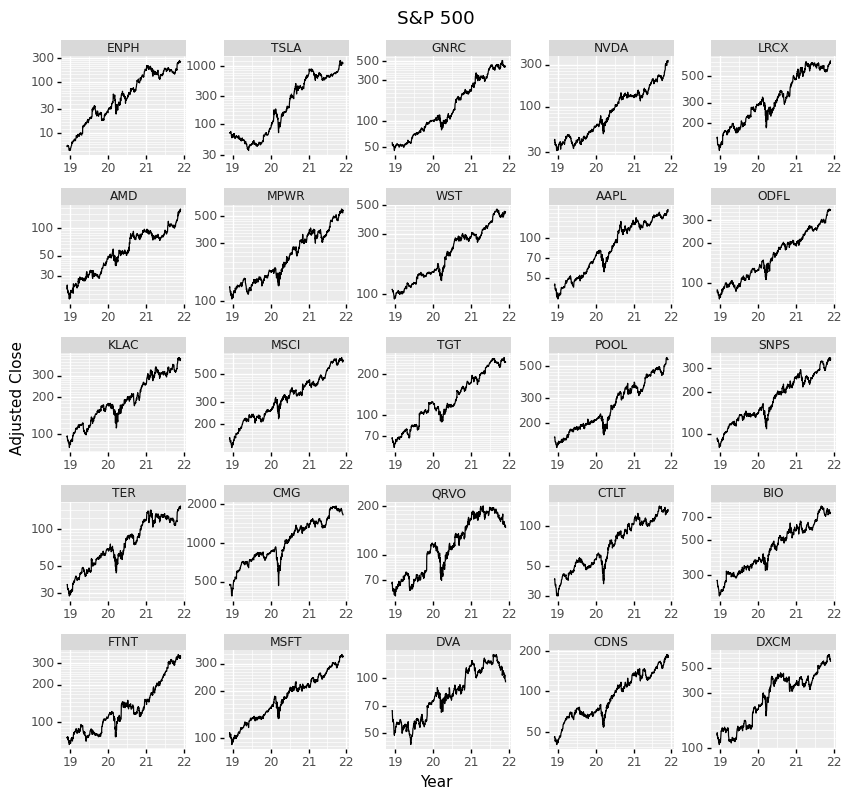

<ggplot: (8778334232507)>

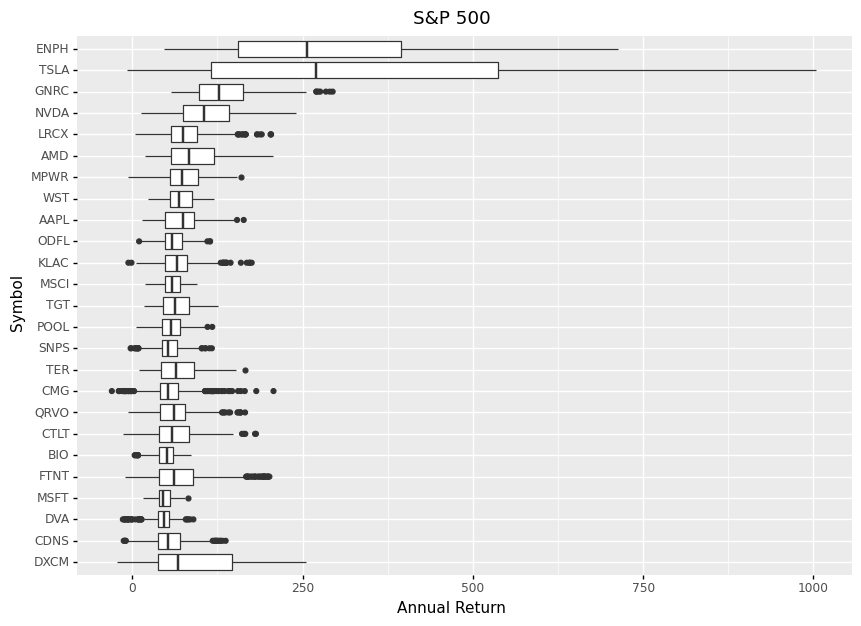

<ggplot: (8778344564944)>

In [5]:
p = plot25_close(sp5_close, sp5_rank_quantile, sp5_title)
display(p)

p = plot25_annual(sp5_annual, sp5_rank_quantile, sp5_title)
display(p)

# PART II: INTERQUANTILE RANGE

In [6]:
def rank_by_iqr(df):
    return (df.quantile(0.75) - df.quantile(0.25)).sort_values().index.tolist()


dow_rank_irq = rank_by_iqr(dow_annual)
sp5_rank_irq = rank_by_iqr(sp5_annual)

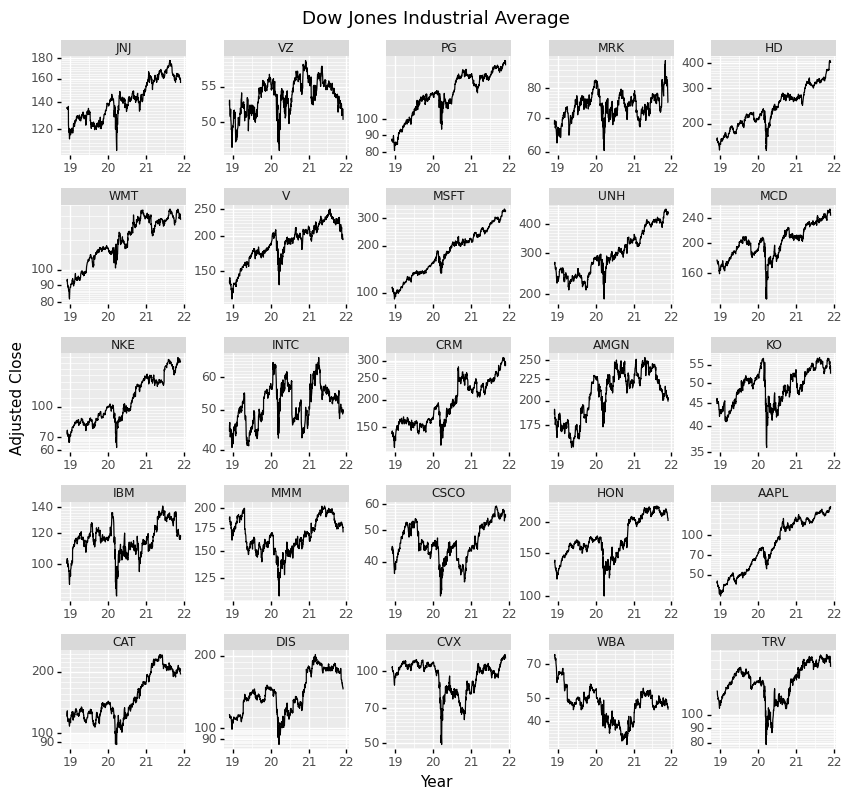

<ggplot: (8778377937951)>

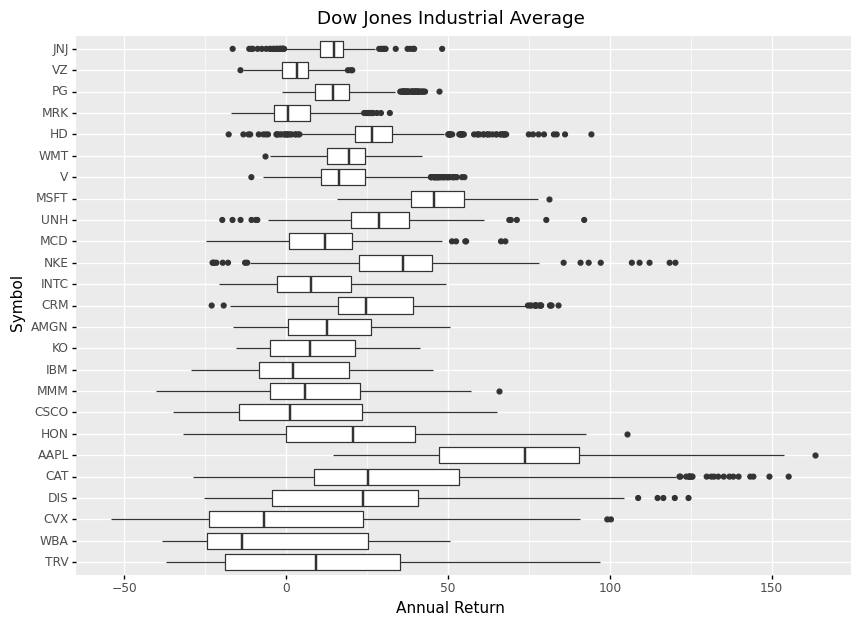

<ggplot: (8778200864497)>

In [7]:
p = plot25_close(dow_close, dow_rank_irq, dow_title)
display(p)

p = plot25_annual(dow_annual, dow_rank_irq, dow_title)
display(p)

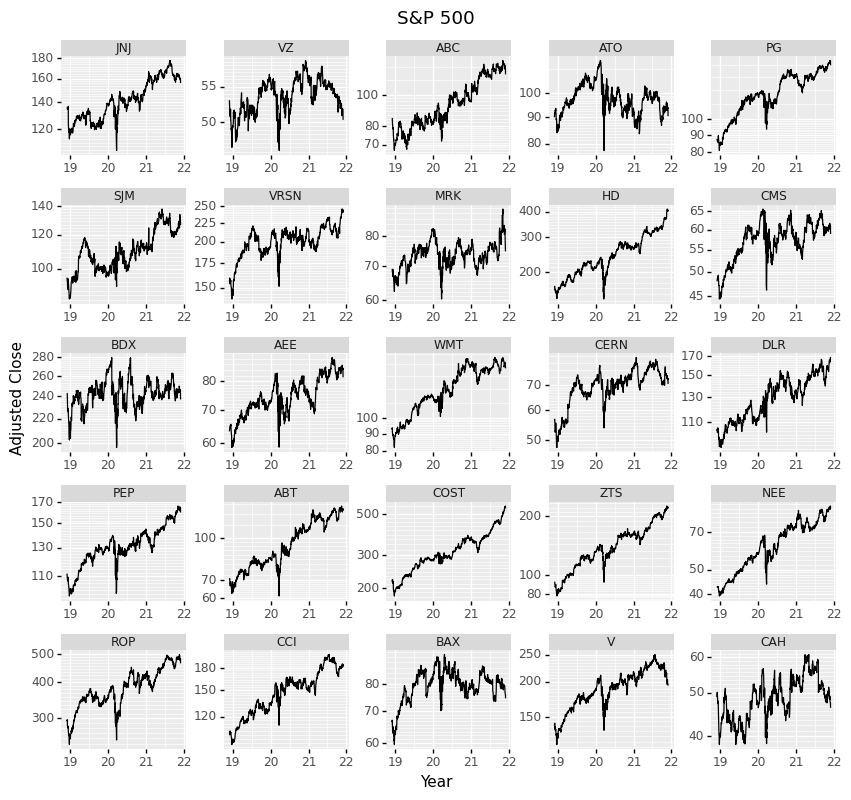

<ggplot: (8778377937957)>

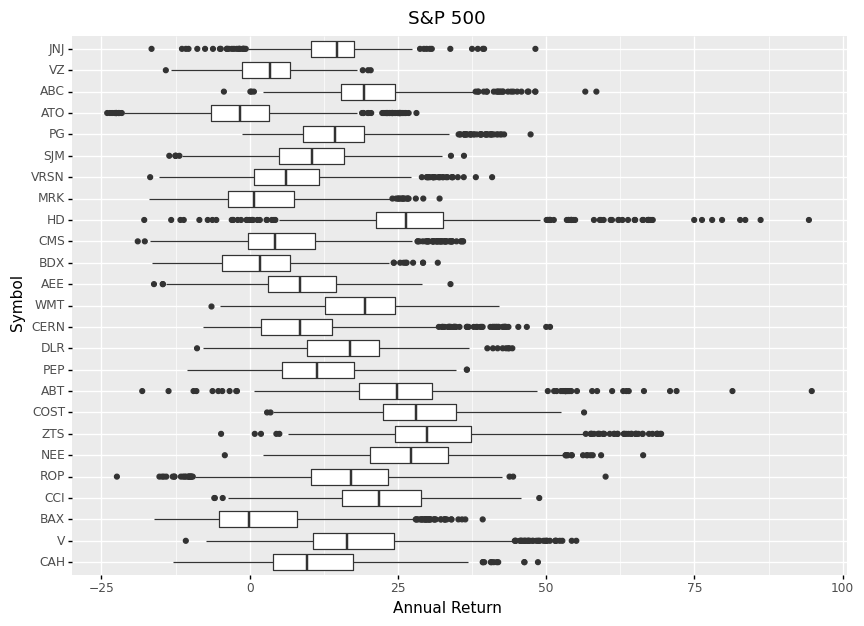

<ggplot: (8778245523104)>

In [8]:
p = plot25_close(sp5_close, sp5_rank_irq, sp5_title)
display(p)

p = plot25_annual(sp5_annual, sp5_rank_irq, sp5_title)
display(p)

# PART III: EXPONENTIAL FIT, RVALUE

In [9]:
from scipy import stats


def get_exp_fit_params_for_series(s):
    x = np.arange(len(s))
    y = np.log(s).to_numpy()
    res = stats.linregress(x, y)
    return pd.Series({'slope': res.slope, 'intercept': res.intercept, 'rvalue': res.rvalue})


def get_exp_fit_params(df):
    return df.apply(get_exp_fit_params_for_series).T


def rank_by_rvalue(df):
    return df['rvalue'].sort_values(ascending=False).index.tolist()


dow_exp_params = get_exp_fit_params(dow_close)
sp5_exp_params = get_exp_fit_params(sp5_close)

dow_rank_rvalue = rank_by_rvalue(dow_exp_params)
sp5_rank_rvalue = rank_by_rvalue(sp5_exp_params)

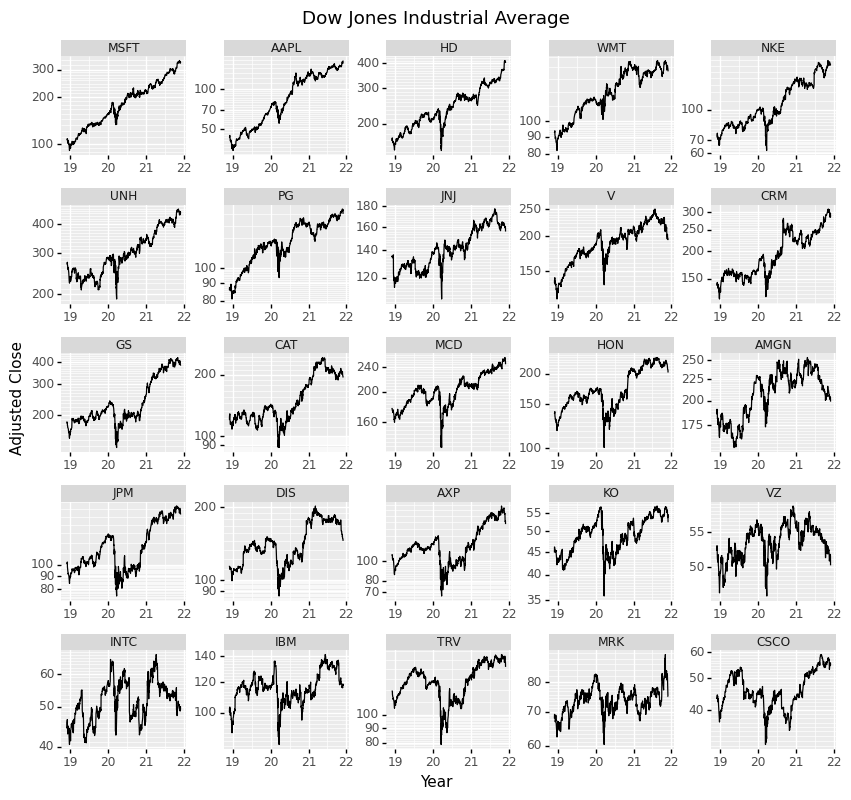

<ggplot: (8778366640547)>

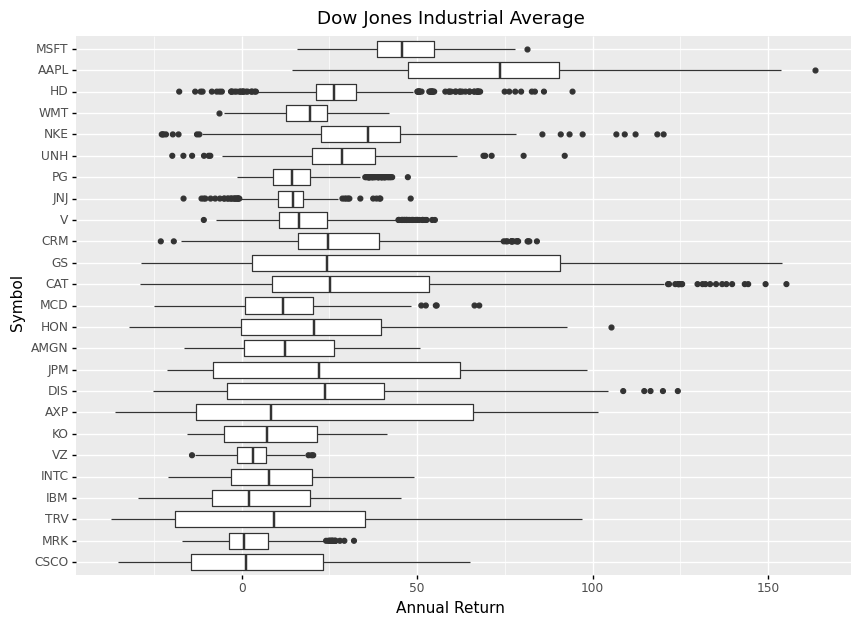

<ggplot: (8778377420267)>

In [10]:
p = plot25_close(dow_close, dow_rank_rvalue, dow_title)
display(p)

p = plot25_annual(dow_annual, dow_rank_rvalue, dow_title)
display(p)

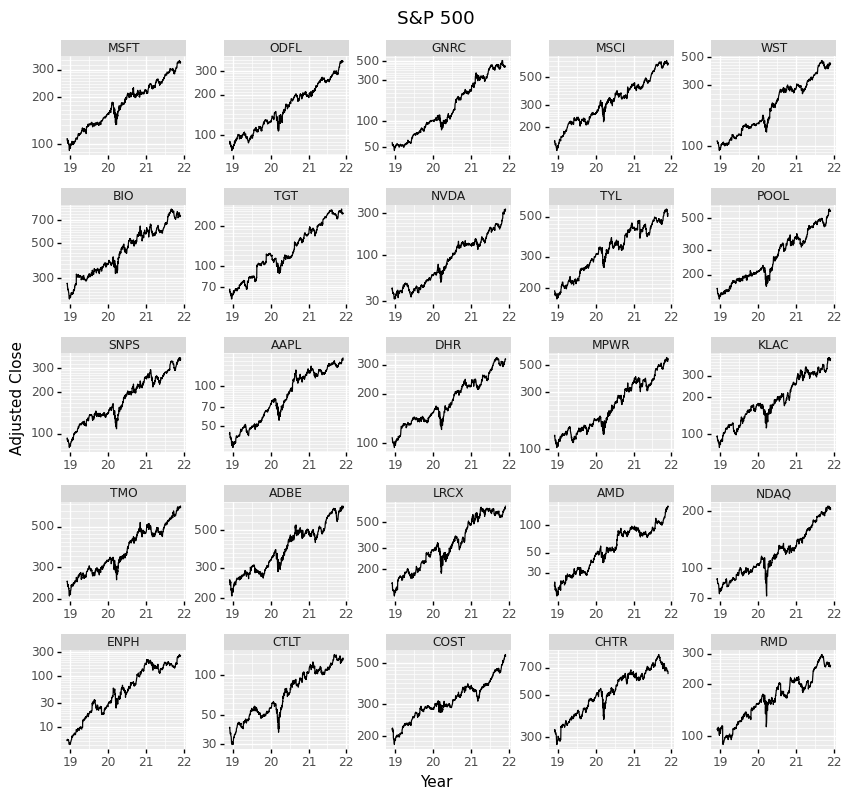

<ggplot: (8778343232368)>

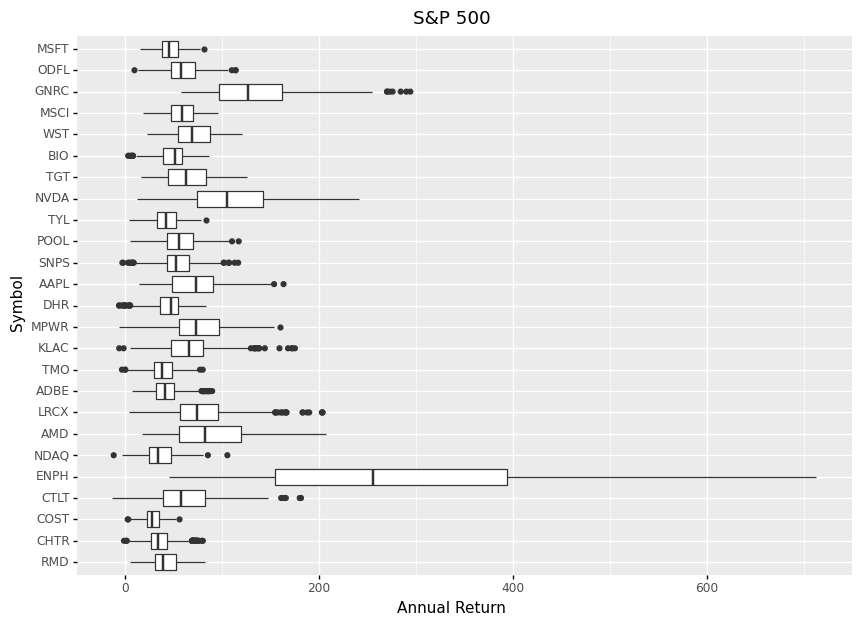

<ggplot: (8778327293109)>

In [11]:
p = plot25_close(sp5_close, sp5_rank_rvalue, sp5_title)
display(p)

p = plot25_annual(sp5_annual, sp5_rank_rvalue, sp5_title)
display(p)

# PART IV: MAXIMUM DRAWDOWN

In [12]:
def get_max_drawdown(df):
    return (1 - df/df.cummax()).max()


def rank_by_max_drawdown(df):
    return df.sort_values().index.to_list()


dow_max_drawdown = get_max_drawdown(dow_close)
sp5_max_drawdown = get_max_drawdown(sp5_close)

dow_rank_drawdown = rank_by_max_drawdown(dow_max_drawdown)
sp5_rank_drawdown = rank_by_max_drawdown(sp5_max_drawdown)

<AxesSubplot:>

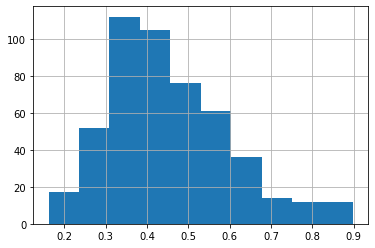

In [19]:
sp5_max_drawdown.hist()

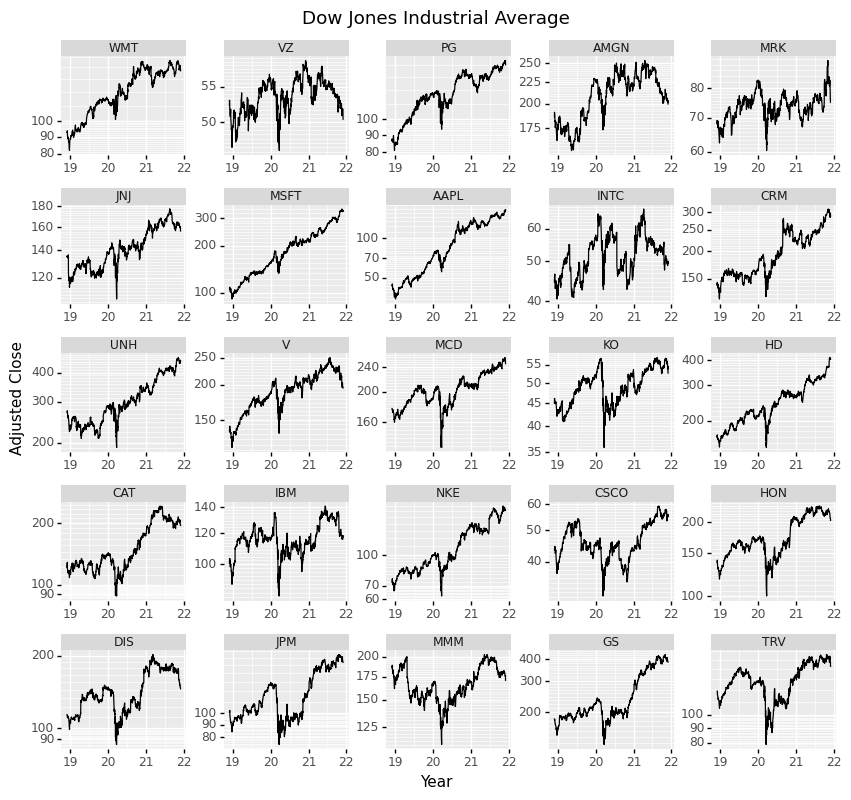

<ggplot: (8778345043791)>

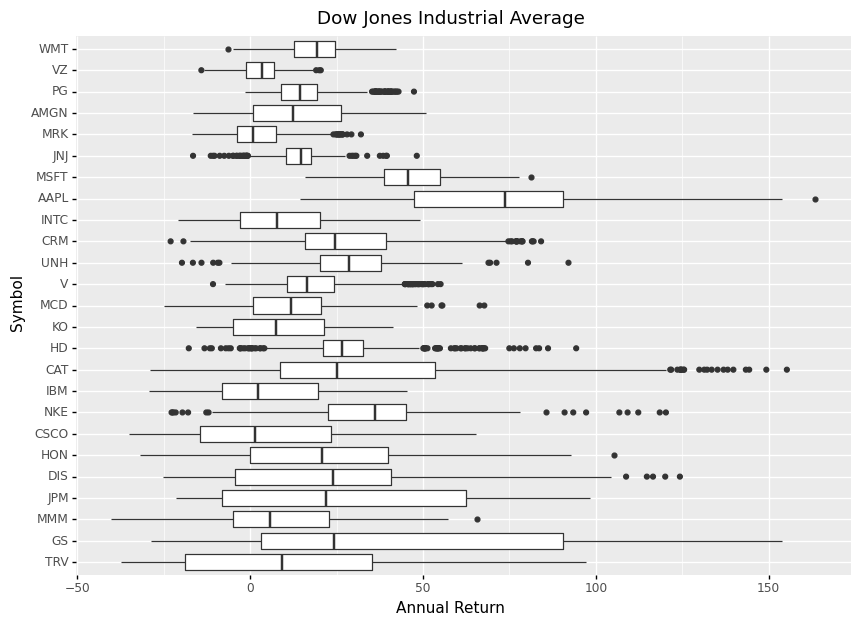

<ggplot: (8778200855489)>

In [13]:
p = plot25_close(dow_close, dow_rank_drawdown, dow_title)
display(p)

p = plot25_annual(dow_annual, dow_rank_drawdown, dow_title)
display(p)

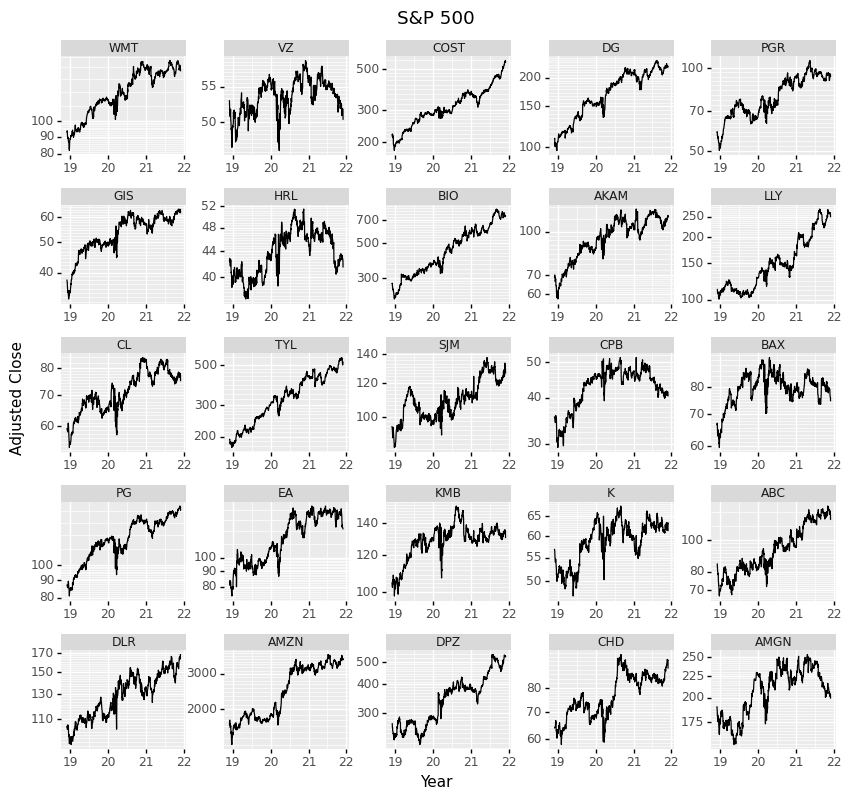

<ggplot: (8778327387389)>

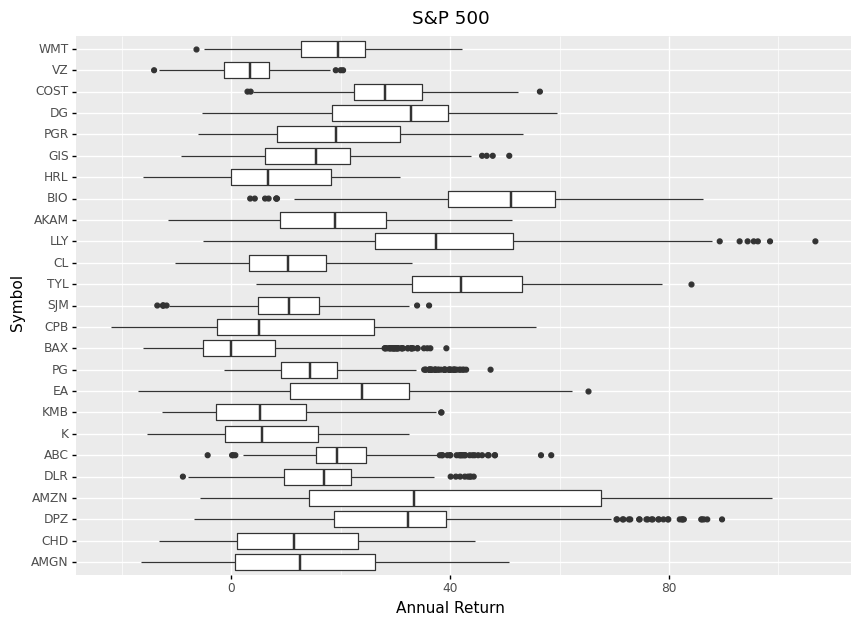

<ggplot: (8778246172880)>

In [14]:
p = plot25_close(sp5_close, sp5_rank_drawdown, sp5_title)
display(p)

p = plot25_annual(sp5_annual, sp5_rank_drawdown, sp5_title)
display(p)

# PART V: MIXED

In [15]:
top_n = 80

set1 = set(sp5_rank_rvalue[:top_n])
set2 = set(sp5_rank_drawdown[:top_n])

intersection =  set1 & set2
symbols = list(intersection)

sp5_rank_quantile = rank_by_first_quantile(sp5_annual[symbols])

len(intersection)

29

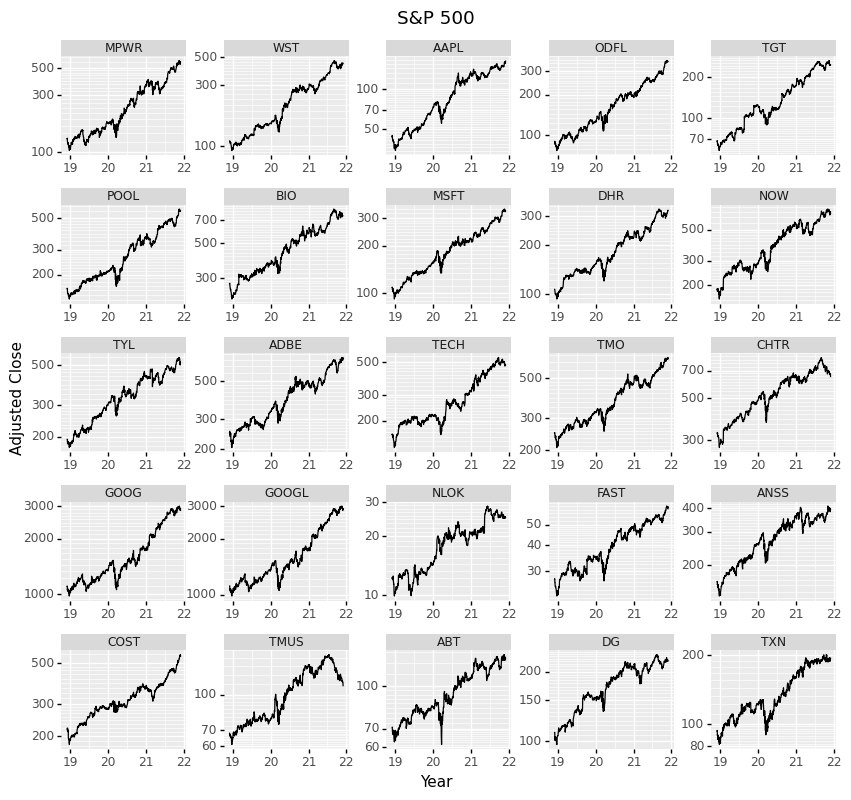

<ggplot: (8778334271898)>

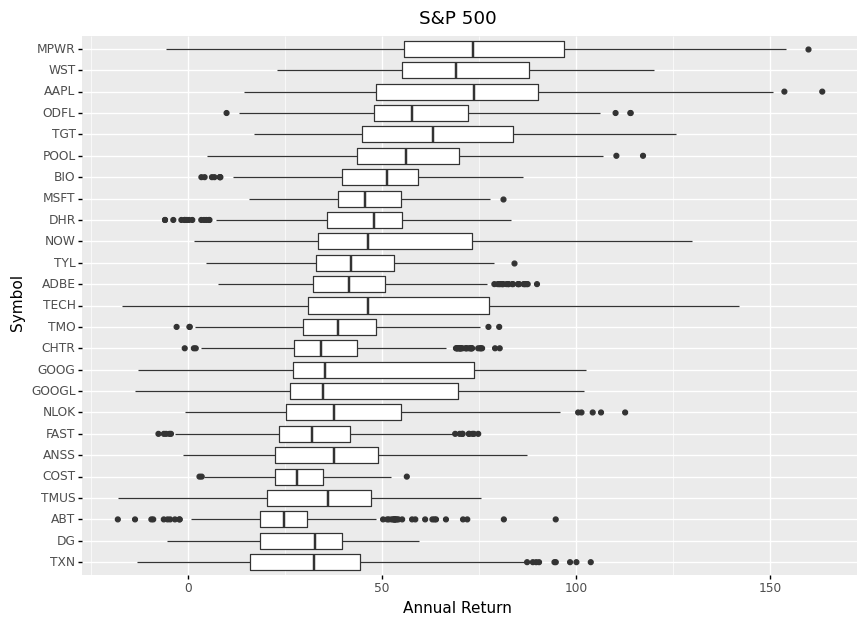

<ggplot: (8778377363875)>

In [16]:
p = plot25_close(sp5_close, sp5_rank_quantile, sp5_title)
display(p)

p = plot25_annual(sp5_annual, sp5_rank_quantile, sp5_title)
display(p)